# Imports

In [129]:
import os
while 'pythonfigures' not in os.listdir():
    os.chdir('..')

In [130]:
from pythonfigures.datapartition import DataPartitioner
from pythonfigures.neuraldatabase import Query
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from scipy.linalg import subspace_angles, null_space, orth
from numpy.linalg import norm

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors

from typing import Optional

import re
import json

# Step 1: active-passive & visuomotor indices (forget about congruence)

In [124]:
# a string parser
def mysplit(s):
    head = s.rstrip('0123456789')
    tail = s[len(head):]
    return head, tail

animal,_ = mysplit('Zara64')
print(animal)

Zara


In [4]:
# set up a list of data-getters
# note: ignore Zara68. It's got too few units and is too temporally close to Zara70 in any case
sessions  = ['Zara64','Zara70','Moe46','Moe50']
areas     = ['AIP','F5','M1']

apidict = dict()
vmidict = dict()

for session in sessions:
    # actually, we made the decision to pool animals. neat!
    # animal,_ = mysplit(session)
    for area in areas:
        print(f'{session} {area}')
        dp = DataPartitioner(session=session,
                            areas=[area],
                            aligns=['cue onset','hold onset'],
                            contexts=['active','passive'],
                            groupings=['context','object','grip','alignment'])
        
        
        
        # get passive-active indices
        df         = dp.readQuery({'context','alignment','grip'})
        df_active  = df[(df['alignment']=='hold onset') & (df['context']=='active')]
        df_passive = df[(df['alignment']=='hold onset') & (df['context']=='passive')]
        
        active_range   = df_active[dp.get('neuronColumnNames')].max() - df_active[dp.get('neuronColumnNames')].min()
        passive_range  = df_passive[dp.get('neuronColumnNames')].max() - df_passive[dp.get('neuronColumnNames')].min()
        
        API            = (active_range - passive_range) / (active_range + passive_range)
        
        if area not in apidict:
            apidict[area] = API.add_suffix(f"_{session}_{area}")
        else:
            apidict[area] = pd.concat((apidict[area],API.add_suffix(f"_{session}_{area}")))
            
        # get visuomotor indices
        df         = dp.readQuery({'context','alignment','object'})
        df_visual  = df[(df['alignment']=='cue onset') & (df['context']=='active')]
        df_motor   = df[(df['alignment']=='hold onset') & (df['context']=='active')]
        
        visual_range   = df_visual[dp.get('neuronColumnNames')].max() - df_visual[dp.get('neuronColumnNames')].min()
        motor_range    = df_motor[dp.get('neuronColumnNames')].max() - df_motor[dp.get('neuronColumnNames')].min()
        
        VMI            = (visual_range - motor_range) / (visual_range + motor_range)
        
        if area not in vmidict:
            vmidict[area] = VMI.add_suffix(f"_{session}_{area}")
        else:
            vmidict[area] = pd.concat((vmidict[area],VMI.add_suffix(f"_{session}_{area}")))

Zara64 AIP
Zara64 F5
Zara64 M1
Zara70 AIP
Zara70 F5
Zara70 M1
Moe46 AIP
Moe46 F5
Moe46 M1
Moe50 AIP
Moe50 F5
Moe50 M1


                    API       VMI area
n0_Zara64_AIP -0.234749 -0.505858  AIP
n1_Zara64_AIP -0.090018 -0.302582  AIP
n2_Zara64_AIP  0.199991 -0.235940  AIP
n3_Zara64_AIP -0.102403  0.443993  AIP
n4_Zara64_AIP -0.149164 -0.197767  AIP
...                 ...       ...  ...
n159_Moe50_M1 -0.183881 -0.330093   M1
n160_Moe50_M1 -0.954784  0.333299   M1
n161_Moe50_M1 -0.032158  0.200754   M1
n162_Moe50_M1 -0.372312 -0.020208   M1
n163_Moe50_M1  0.482623 -0.660278   M1

[1632 rows x 3 columns]


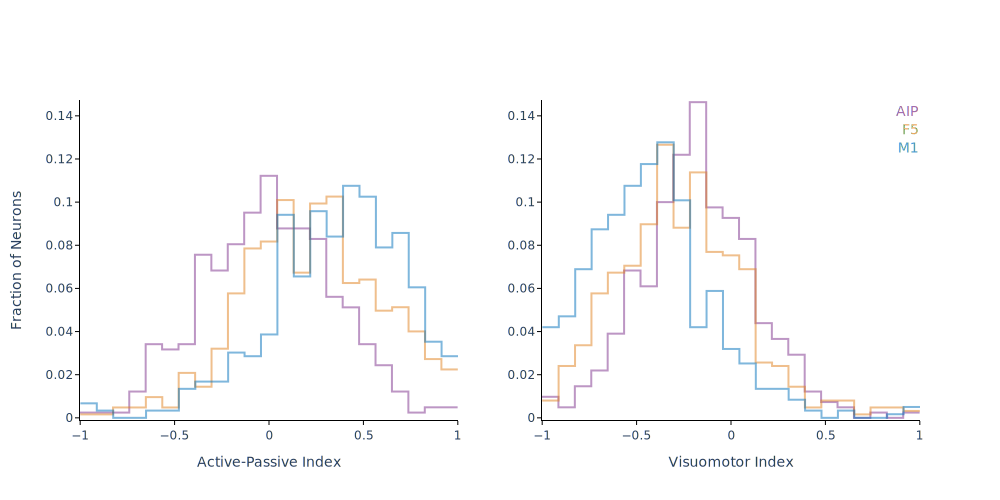

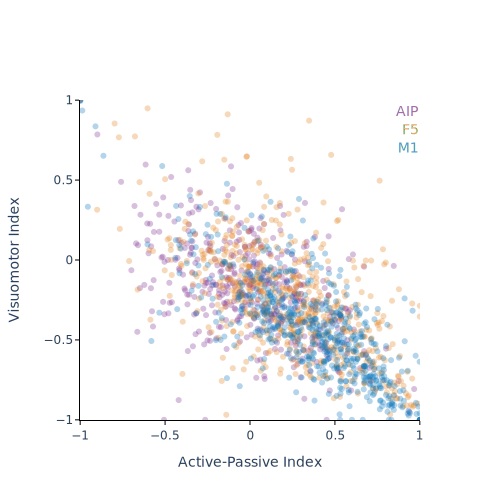

In [5]:
# now plot!
df_list = []
for area in areas:
    api = apidict[area]
    vmi = vmidict[area]
    
    df_list += [pd.DataFrame({'API':api,'VMI':vmi,'area':[area for x in range(len(api))]})]
    
dfcombo = pd.concat( tuple(df_list) )
print(dfcombo)

histhandle = make_subplots(rows=1,cols=2)
colors = pd.read_csv(os.path.join('pythonfigures','colors.csv'))
shift = -.001
maxfreq = 0
for area in areas:
    df_ = dfcombo[dfcombo['area']==area]
    api     = df_['API'].to_numpy()
    vmi     = df_['VMI'].to_numpy()
    bedges  = np.linspace(-1,1,24)
    apihist,_ = np.histogram(api,bins=bedges)
    vmihist,_ = np.histogram(vmi,bins=bedges)
    
    maxfreq = max(maxfreq,max(apihist/sum(apihist)),max(vmihist/sum(vmihist)))
    
    c  = colors[colors["Area"]==area].to_numpy()
    c  = c[0][:3]
    
    # API histogram
    histhandle.add_trace(
        go.Scatter(
            x=bedges+shift,
            y=np.append(apihist/sum(apihist),apihist[-1]/sum(apihist)),
            name=area,
            line={
                'color':f'rgba({c[0]},{c[1]},{c[2]},0.5)',
                'shape':'hv'
            },
        ),
        row=1,
        col=1
    )
    
    # VMI histogram
    histhandle.add_trace(
        go.Scatter(
            x=bedges+shift,
            y=np.append(vmihist/sum(vmihist),vmihist[-1]/sum(vmihist)),
            name=area,
            line={
                'color':f'rgba({c[0]},{c[1]},{c[2]},0.5)',
                'shape':'hv'
            },
        ),
        row=1,
        col=2
    )
    
    shift+=.001

    
# pop back out of the loop
histhandle.update_xaxes(ticks='outside',
                           tickwidth=1,
                           tickcolor='black',
                           ticklen=4,
                           linecolor='rgba(0,0,0,1)',
                           linewidth=1)

histhandle.update_yaxes(ticks='outside',
                               tickwidth=1,
                               tickcolor='black',
                               ticklen=4,
                               linecolor='rgba(0,0,0,1)',
                               linewidth=1
                               )

# guess I gotta go low-level for this
histhandle['layout']['xaxis']['title'] = 'Active-Passive Index'
histhandle['layout']['xaxis2']['title'] = 'Visuomotor Index'
histhandle['layout']['yaxis']['range'] = [-0.001,maxfreq+0.001]
histhandle['layout']['yaxis2']['range'] = [-0.001,maxfreq+0.001]

histhandle.update_layout(
    yaxis_title='Fraction of Neurons',
    plot_bgcolor='rgba(0,0,0,0)' ,
    paper_bgcolor='rgba(0,0,0,0)',
    showlegend=False,
    autosize=False,
    width=1000,
    height=500
)

# I also need to do janky things to make a custom legend, too! wow!
prepend=''
for area in areas:
    c  = colors[colors["Area"]==area].to_numpy()
    c  = c[0][:3]

    histhandle.add_annotation(xref='x domain',
                                     yref='y domain',
                                     x = 1,
                                     y = 1,
                                     text = prepend+area,
                                     showarrow=False,
                                     font={
                                         'color':f'rgba({c[0]},{c[1]},{c[2]},0.7)',
                                         'size':14
                                         },
                                     align='right',
                                     valign='top',
                                     yanchor='top',
                                     xanchor='right',
                                     row=1,
                                     col=2)

    prepend+=' <br>' # needs a space


histhandle.show(renderer="svg")

# now one more scatterplot
scatterhandle = make_subplots(rows=1,cols=1)
for area in areas:
    c  = colors[colors["Area"]==area].to_numpy()
    c  = c[0][:3]
    
    df_ = dfcombo[dfcombo['area']==area]
    api     = df_['API'].to_numpy()
    vmi     = df_['VMI'].to_numpy()
    
    scatterhandle.add_trace(
        go.Scatter(
            x=api,
            y=vmi,
            name=area,
            mode='markers',
            line={
                'color':f'rgba({c[0]},{c[1]},{c[2]},0.3)',
            }
        ),
        row=1,
        col=1
    )
    
# pop back out of the loop
scatterhandle.update_xaxes(ticks='outside',
                           tickwidth=1,
                           tickcolor='black',
                           ticklen=4,
                           linecolor='rgba(0,0,0,1)',
                           linewidth=1)

scatterhandle.update_yaxes(ticks='outside',
                               tickwidth=1,
                               tickcolor='black',
                               ticklen=4,
                               linecolor='rgba(0,0,0,1)',
                               linewidth=1
                               )

# guess I gotta go low-level for this
scatterhandle['layout']['xaxis']['title'] = 'Active-Passive Index'
scatterhandle['layout']['xaxis']['range'] = [-1.001,1.001]
scatterhandle['layout']['yaxis']['title'] = 'Visuomotor Index'
scatterhandle['layout']['yaxis']['range'] = [-1.001,1.001]

scatterhandle.update_layout(
    plot_bgcolor='rgba(0,0,0,0)' ,
    paper_bgcolor='rgba(0,0,0,0)',
    showlegend=False,
    autosize=False,
    width=500,
    height=500
)

# I also need to do janky things to make a custom legend, too! wow!
prepend=''
for area in areas:
    c  = colors[colors["Area"]==area].to_numpy()
    c  = c[0][:3]

    scatterhandle.add_annotation(xref='x domain',
                                     yref='y domain',
                                     x = 1,
                                     y = 1,
                                     text = prepend+area,
                                     showarrow=False,
                                     font={
                                         'color':f'rgba({c[0]},{c[1]},{c[2]},0.7)',
                                         'size':14
                                         },
                                     align='right',
                                     valign='top',
                                     yanchor='top',
                                     xanchor='right',
                                     row=1,
                                     col=1)

    prepend+=' <br>' # needs a space
    
scatterhandle.show(renderer="svg")

# no evidence of clustering here!
# that said, we probably won't be using this plot
# even though it fits perfectly with the story...

# Step 2: Perform orthogonalization and verify it behaves correctly

In [6]:
# intermission: import your ML Buddy
# nevermind it'll take too long!

# remember: keep it simple!
# just show you can abolish cross-classification with the visual period
# while ALSO preserving within-context grip classification accuracy!

In [7]:
orthocounts = dict()
for session in sessions:
    orthocounts[session] = dict()
    for area in areas:
        print(f"{session} {area}")
        dp = DataPartitioner(session=session,
                            areas=[area],
                            aligns=['cue onset','hold onset'],
                            contexts=['active','passive'],
                            groupings=['context','object','grip','turntable','alignment'])
        
        df = dp.readQuery(0)

        df_vision_trials   = df[(df['alignment']=='cue onset') & (df['time']>0)].groupby(['object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
        labels             = df_vision_trials.index.get_level_values(0)

        flag          = False
        axesToRemove  = 0
        neurcount     = len(dp.get('neuronColumnNames'))
        pccount       = 30
        nsplits       = 5

        skf     = StratifiedKFold(n_splits=nsplits,shuffle=False)
        splits  = skf.split(np.zeros(len(labels)),labels)
        splits  = list(splits) # store as list to allow it to be used many of time
        PCmdls  = []
        deltamu = []

        # step 1: find the set of axes for each split
        for train_,_ in splits:
            df_vision_agg = df_vision_trials.iloc[train_].groupby(level=[0]).aggregate('mean')
            n_components = min(df_vision_agg.shape) - 1
            PCmdl = PCA(n_components=n_components)
            PCmdl.fit(df_vision_agg.to_numpy())
            PCmdls+=[PCmdl]

            # no delta-mus needed

        # step 2: iterate model fitting
        maxAxesToRemove = PCmdls[0].n_components_
        while not flag:
            correct_count = 0
            chance_count  = 0
            total_count   = len(labels)

            for fold,(train_,test_) in enumerate(splits):
                trainX = df_vision_trials.iloc[train_]
                trainy = labels[train_].to_numpy()

                testX  = df_vision_trials.iloc[test_]
                testy  = labels[test_].to_numpy()

                if axesToRemove > 0:
                    nullSpace = null_space( np.matrix(PCmdls[fold].components_[:axesToRemove,:]) )
                else:
                    nullSpace = np.eye(neurcount)

                # projections
                trainX = trainX.to_numpy() @ nullSpace
                testX  = testX.to_numpy() @ nullSpace

                # no deltamu to get rid of

                # now fit a PC model in the remaining space to make sure LDA input is well-conditioned (this improves cross-validated performance)
                PCmdl = PCA(n_components=pccount)
                trainX = PCmdl.fit_transform(trainX)
                testX  = PCmdl.transform(testX)

                # now we can finally start classifying!
                LDmdl = LDA()
                LDmdl.fit(trainX,trainy)
                yhat = LDmdl.predict(testX)

                correct_count += np.sum(yhat==testy)
                chance_count  += len(testy) * max(LDmdl.priors_)

            correct_rate   = correct_count / total_count
            chance_rate    = chance_count / total_count
            threshold_rate = chance_rate + np.sqrt( chance_rate*(1-chance_rate)/total_count ) # chance + 1 SE

            print(f"    Removed axes = {axesToRemove}")
            print(f"    Accuracy = {correct_rate}")
            print(f"    Chance = {chance_rate}")
            print(f"    Threshold = {threshold_rate}")
            print()

            if correct_rate > threshold_rate and axesToRemove<maxAxesToRemove:
                axesToRemove+=1
            else:
                flag = True

        print(f"    Final result: remove {axesToRemove} axes")
        print()
        print()
        
        orthocounts[session][area] = axesToRemove

Zara64 AIP
    Removed axes = 0
    Accuracy = 0.46774193548387094
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 1
    Accuracy = 0.39919354838709675
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 2
    Accuracy = 0.30443548387096775
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 3
    Accuracy = 0.24193548387096775
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 4
    Accuracy = 0.1875
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 5
    Accuracy = 0.14516129032258066
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 6
    Accuracy = 0.11895161290322581
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 7
    Accuracy = 0.10887096774193548
    Chance = 0.08064557166694161
    Threshold = 0.0928717551835

    Removed axes = 4
    Accuracy = 0.2741652021089631
    Chance = 0.08348011098450465
    Threshold = 0.09507606067846915

    Removed axes = 5
    Accuracy = 0.2601054481546573
    Chance = 0.08348011098450465
    Threshold = 0.09507606067846915

    Removed axes = 6
    Accuracy = 0.20738137082601055
    Chance = 0.08348011098450465
    Threshold = 0.09507606067846915

    Removed axes = 7
    Accuracy = 0.19332161687170474
    Chance = 0.08348011098450465
    Threshold = 0.09507606067846915

    Removed axes = 8
    Accuracy = 0.17223198594024605
    Chance = 0.08348011098450465
    Threshold = 0.09507606067846915

    Removed axes = 9
    Accuracy = 0.14938488576449913
    Chance = 0.08348011098450465
    Threshold = 0.09507606067846915

    Removed axes = 10
    Accuracy = 0.13181019332161686
    Chance = 0.08348011098450465
    Threshold = 0.09507606067846915

    Removed axes = 11
    Accuracy = 0.11775043936731107
    Chance = 0.08348011098450465
    Threshold = 0.09507606067

In [8]:
# armed with our orthocounts dictionary, let's now verify that it successfully abolishes our ability to use movement-period data with a classifier trained on visual data
crossaccs = dict()

for session in sessions:
    crossaccs[session] = dict()
    
    for area in areas:
        print(f"{session} {area}")
        crossaccs[session][area] = dict()
        
        dp = DataPartitioner(session=session,
                            areas=[area],
                            aligns=['cue onset','hold onset'],
                            contexts=['active','passive'],
                            groupings=['context','object','grip','turntable','alignment'])
        
        df = dp.readQuery(0)

        df_vision_trials   = df[(df['alignment']=='cue onset') & (df['time']>0)].groupby(['object','trial'],sort=False)[dp.get('neuronColumnNames')].aggregate('mean')
        df_movement_trials = df[(df['alignment']=='hold onset') & (df['time']<0)].groupby(['object','trial'],sort=False)[dp.get('neuronColumnNames')].aggregate('mean')
        labels             = df_vision_trials.index.get_level_values(0)

        flag          = False
        axesToRemove  = 0
        neurcount     = len(dp.get('neuronColumnNames'))
        pccount       = 30
        nsplits       = 5

        skf     = StratifiedKFold(n_splits=nsplits,shuffle=False)
        splits  = skf.split(np.zeros(len(labels)),labels)
        splits  = list(splits) # store as list to allow it to be used many of time
        PCmdls  = []
        deltamu = []

        # step 1: find the set of axes for each split
        for train_,_ in splits:
            df_vision_agg = df_vision_trials.iloc[train_].groupby(level=[0]).aggregate('mean')
            n_components = min(df_vision_agg.shape) - 1
            PCmdl = PCA(n_components=n_components)
            PCmdl.fit(df_vision_agg.to_numpy())
            PCmdls+=[PCmdl]

            # also compute delta-mu
            deltamu += [(df_vision_trials.mean() - df_movement_trials.mean()).to_numpy()]

        # step 2: cross-validated model fitting & evaluation
        idx=0
        for axesToRemove in [0,orthocounts[session][area]]:
            correct_count = 0
            chance_count  = 0
            total_count   = len(labels)

            for fold,(train_,test_) in enumerate(splits):
                trainX = df_vision_trials.iloc[train_]
                trainy = labels[train_].to_numpy()

                testX  = df_movement_trials.iloc[test_]
                testy  = labels[test_].to_numpy()

                if axesToRemove > 0:
                    nullSpace = null_space( np.matrix(PCmdls[fold].components_[:axesToRemove,:]) )
                else:
                    nullSpace = np.eye(neurcount)

                # projections
                trainX = trainX.to_numpy() @ nullSpace
                testX  = testX.to_numpy() @ nullSpace
                
                # deltamu removal
                dmu = deltamu[fold] @ nullSpace
                dmu_null = null_space( np.matrix(dmu) )

                # now fit a PC model in the remaining space to make sure LDA input is well-conditioned (this improves cross-validated performance)
                PCmdl = PCA(n_components=pccount)
                trainX = PCmdl.fit_transform(trainX @ dmu_null)
                testX  = PCmdl.transform(testX @ dmu_null)

                # now we can finally start classifying!
                LDmdl = LDA()
                LDmdl.fit(trainX,trainy)
                yhat = LDmdl.predict(testX)

                correct_count += np.sum(yhat==testy)
                chance_count  += len(testy) * max(LDmdl.priors_)

            correct_rate   = correct_count / total_count
            chance_rate    = chance_count / total_count
            threshold_rate = chance_rate + np.sqrt( chance_rate*(1-chance_rate)/total_count ) # chance + 1 SE
            
            temp = dict()
            temp['correct_count'] = correct_count
            temp['chance_count']  = chance_count
            temp['total_count']   = total_count
            temp['removed_axes']  = axesToRemove
            temp['neuron_count']  = len(dp.get('neuronColumnNames'))
            
            if idx==0:
                crossaccs[session][area]['naive'] = temp
            else:
                crossaccs[session][area]['orthogonalized'] = temp
            
            print(f"    Removed axes = {axesToRemove}")
            print(f"    Number of neurons = {len(dp.get('neuronColumnNames'))}")
            print(f"    Accuracy = {correct_rate}")
            print(f"    Chance = {chance_rate}")
            print(f"    Threshold = {threshold_rate}")
            print()
            idx+=1

Zara64 AIP
    Removed axes = 0
    Number of neurons = 121
    Accuracy = 0.3487903225806452
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 10
    Number of neurons = 121
    Accuracy = 0.08266129032258064
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

Zara64 F5
    Removed axes = 0
    Number of neurons = 121
    Accuracy = 0.14516129032258066
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 10
    Number of neurons = 121
    Accuracy = 0.0625
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

Zara64 M1
    Removed axes = 0
    Number of neurons = 99
    Accuracy = 0.125
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

    Removed axes = 2
    Number of neurons = 99
    Accuracy = 0.05443548387096774
    Chance = 0.08064557166694161
    Threshold = 0.09287175518355723

Zara70 AIP
    Removed axes = 0
    Number of neurons = 121
    Accuracy 

In [9]:
# get the data ready for plotting
# x = before
# y = after

pre_     = []
post_    = []
pre_se   = []
post_se  = []
chance   = []
session_ = []
animal   = []
area_    = []

for session in crossaccs:
    for area in crossaccs[session]:
        temp = crossaccs[session][area]
        pre_ +=[temp['naive']['correct_count']/temp['naive']['total_count']]
        post_+=[temp['orthogonalized']['correct_count']/temp['orthogonalized']['total_count']]
        pre_se+=[( pre_[-1]*(1-pre_[-1])/temp['naive']['total_count'] )]
        post_se+=[( post_[-1]*(1-post_[-1])/temp['orthogonalized']['total_count'] )] # keep it squared so you can sum them
        chance+=[temp['naive']['chance_count'] / temp['naive']['total_count']] # chance should be the same across both naive & orthogonalized
        session_+=[session]
        
        an,_ = mysplit(session)
        
        animal+=[an]
        area_+=[area]
        
dd = {'naive':pre_,
      'orthogonalized':post_,
      'naive_se2':pre_se,
      'orthogonalized_se2':post_se,
      'chance':chance,
      'session':session_,
      'animal':animal,
      'area':area_}

df = pd.DataFrame(dd)

print(df)



mu = df.groupby(['area'])[['naive','orthogonalized','naive_se2','orthogonalized_se2']].mean()
se = df.groupby(['area'])[['naive','orthogonalized']].sem()
print(mu)
print(se)

       naive  orthogonalized  naive_se2  orthogonalized_se2    chance session  \
0   0.348790        0.082661   0.000458            0.000153  0.080646  Zara64   
1   0.145161        0.062500   0.000250            0.000118  0.080646  Zara64   
2   0.125000        0.054435   0.000221            0.000104  0.080646  Zara64   
3   0.272152        0.099156   0.000418            0.000188  0.084389  Zara70   
4   0.145570        0.084388   0.000262            0.000163  0.084389  Zara70   
5   0.078059        0.078059   0.000152            0.000152  0.084389  Zara70   
6   0.332180        0.077855   0.000384            0.000124  0.085202   Moe46   
7   0.150519        0.096886   0.000221            0.000151  0.085202   Moe46   
8   0.124567        0.062284   0.000189            0.000101  0.085202   Moe46   
9   0.442882        0.065026   0.000434            0.000107  0.083480   Moe50   
10  0.121265        0.072056   0.000187            0.000118  0.083480   Moe50   
11  0.089631        0.089631

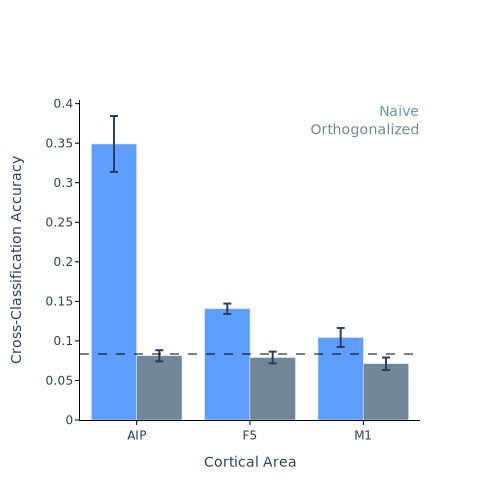

In [10]:
# and plot
fig = go.Figure()
# fig.full_figure_for_development()
fig.add_trace(go.Bar(
    name='Naive',
    marker_color='rgba(26, 118, 255, 0.7)',
    x=[0,1,2], y=mu['naive'].to_list(),
    error_y=dict(type='data', array=se['naive'].to_list())
))
fig.add_trace(go.Bar(
    name='Orthogonalized',
    marker_color='rgba(55, 83, 109, 0.7)',
    x=[0,1,2], y=mu['orthogonalized'].to_list(),
    error_y=dict(type='data', array=se['orthogonalized'].to_list())
))

fig.update_xaxes(ticks='outside',
                           tickwidth=1,
                           tickcolor='black',
                           ticklen=4,
                           linecolor='rgba(0,0,0,1)',
                           linewidth=1,
                           showgrid=False)

fig.update_yaxes(ticks='outside',
                               tickwidth=1,
                               tickcolor='black',
                               ticklen=4,
                               linecolor='rgba(0,0,0,1)',
                               linewidth=1,
                               showgrid=False
                               )

# guess I gotta go low-level for this
fig['layout']['xaxis']['title'] = 'Cortical Area'
fig['layout']['xaxis']['range'] = [-0.5, 2.5]
fig['layout']['yaxis']['title'] = 'Cross-Classification Accuracy'
fig['layout']['xaxis']['ticktext'] = ['AIP','F5','M1']
fig['layout']['xaxis']['tickvals'] = [0,1,2]

fig.add_trace(
    go.Scatter(
        x=[-0.5,2.5],
        y=[df['chance'].mean() for _ in range(2)],
        name='chance',
        mode='lines',
        line={
            'color':f'rgba(0,0,0,0.5)',
            'dash':'dash'
        }
    ),
)

fig.update_layout(barmode='group',
    plot_bgcolor='rgba(0,0,0,0)' ,
    paper_bgcolor='rgba(0,0,0,0)',
    showlegend=False,
    autosize=False,
    width=500,
    height=500)

# I also need to do janky things to make a custom legend, too! wow!

colors = ['rgba(26, 118, 255, 0.7)','rgba(55, 83, 109, 0.7)']
prepend=''
for idx,legent in enumerate(['Naive','Orthogonalized']):
    c  = colors[idx]

    fig.add_annotation(xref='x domain',
                                     yref='y domain',
                                     x = 1,
                                     y = 1,
                                     text = prepend+legent,
                                     showarrow=False,
                                     font={
                                         'color':c,
                                         'size':14
                                         },
                                     align='right',
                                     valign='top',
                                     yanchor='top',
                                     xanchor='right')

    prepend+=' <br>' # needs a space
    
fig.show(renderer="svg")
fig.write_image(os.path.join('figs','Vision_Movement_Cross.svg'))

In [11]:
# now, self-classification
selfaccs = dict()

for session in sessions:
    selfaccs[session] = dict()
    
    for area in areas:
        selfaccs[session][area] = dict()
        
        dp = DataPartitioner(session=session,
                            areas=[area],
                            aligns=['cue onset','hold onset'],
                            contexts=['active','passive'],
                            groupings=['context','object','grip','turntable','alignment'])
        
        df = dp.readQuery(0)
        df['turntable'] = df['turntable'] // 10
        
        
        df_vision_trials   = df[(df['alignment']=='cue onset') & (df['time']>0)].groupby(['context','turntable','object','trial'],sort=False)[dp.get('neuronColumnNames')].aggregate('mean')
        df_movement_trials = df[(df['alignment']=='hold onset') & (df['time']<0)].groupby(['context','turntable','grip','trial'],sort=False)[dp.get('neuronColumnNames')].aggregate('mean')
        
        df_vision_trials
        
        # okay, let's iterate through contexts
        for context in ['active','passive']:
            print(f"{session} {area} {context}")
            selfaccs[session][area][context] = dict()
            
            # extract the context (and ignore the special turntable to get your chance level under control... but DO leave it in when estimating the subspace spanned by the object vision repertoire)
            df_movement_context  = df_movement_trials.loc[(df_movement_trials.index.get_level_values(0)==context) & (df_movement_trials.index.get_level_values(1)!=9)] # keep the context multiindex level here, too
            df_vision_context    = df_vision_trials.loc[(df_vision_trials.index.get_level_values(0)==context) & (df_vision_trials.index.get_level_values(1)!=9)] # keep the context multiindex level to enable aggregation after concatenation
            df_vision_offcontext = df_vision_trials.loc[(df_vision_trials.index.get_level_values(0)!=context) |  (df_vision_trials.index.get_level_values(1)==9)]
            
            labels = df_movement_context.index.get_level_values(2)
            
            axesToRemove  = 0
            neurcount     = len(dp.get('neuronColumnNames'))
            pccount       = 30
            nsplits       = 5

            skf     = StratifiedKFold(n_splits=nsplits,shuffle=False)
            splits  = skf.split(np.zeros(len(labels)),labels)
            splits  = list(splits) # store as list to allow it to be used many of time
            PCmdls  = []

            # step 1: find the set of axes for each split
            for train_,_ in splits:
                df_vision_cat = pd.concat( (df_vision_context.iloc[train_],df_vision_offcontext) )
                df_vision_agg = df_vision_cat.groupby(level=[1]).aggregate('mean')
                n_components = min(df_vision_agg.shape) - 1
                PCmdl = PCA(n_components=n_components)
                PCmdl.fit(df_vision_agg.to_numpy())
                PCmdls+=[PCmdl]

                # no need for deltamu here

            # step 2: cross-validated model fitting & evaluation
            idx=0
            for axesToRemove in [0,orthocounts[session][area]]:
                correct_count = 0
                chance_count  = 0
                total_count   = len(labels)

                for fold,(train_,test_) in enumerate(splits):
                    trainX = df_movement_context.iloc[train_]
                    trainy = labels[train_].to_numpy()

                    testX  = df_movement_context.iloc[test_]
                    testy  = labels[test_].to_numpy()

                    if axesToRemove > 0:
                        nullSpace = null_space( np.matrix(PCmdls[fold].components_[:axesToRemove,:]) )
                    else:
                        nullSpace = np.eye(neurcount)

                    # projections
                    trainX = trainX.to_numpy() @ nullSpace
                    testX  = testX.to_numpy() @ nullSpace

                    # no deltamu removal needed

                    # now fit a PC model in the remaining space to make sure LDA input is well-conditioned (this improves cross-validated performance)
                    PCmdl = PCA(n_components=pccount)
                    trainX = PCmdl.fit_transform(trainX)
                    testX  = PCmdl.transform(testX)

                    # now we can finally start classifying!
                    LDmdl = LDA()
                    LDmdl.fit(trainX,trainy)
                    yhat = LDmdl.predict(testX)

                    correct_count += np.sum(yhat==testy)
                    chance_count  += len(testy) * max(LDmdl.priors_)

                correct_rate   = correct_count / total_count
                chance_rate    = chance_count / total_count
                threshold_rate = chance_rate + np.sqrt( chance_rate*(1-chance_rate)/total_count ) # chance + 1 SE

                temp = dict()
                temp['correct_count'] = correct_count
                temp['chance_count']  = chance_count
                temp['total_count']   = total_count
                temp['removed_axes']  = axesToRemove
                temp['neuron_count']  = len(dp.get('neuronColumnNames'))

                if idx==0:
                    selfaccs[session][area][context]['naive'] = temp
                else:
                    selfaccs[session][area][context]['orthogonalized'] = temp

                print(f"    Removed axes = {axesToRemove}")
                print(f"    Number of neurons = {len(dp.get('neuronColumnNames'))}")
                print(f"    Accuracy = {correct_rate}")
                print(f"    Chance = {chance_rate}")
                print(f"    Threshold = {threshold_rate}")
                print()
                idx+=1

Zara64 AIP active
    Removed axes = 0
    Number of neurons = 121
    Accuracy = 0.6779661016949152
    Chance = 0.22033221083926324
    Threshold = 0.2514857333437951

    Removed axes = 10
    Number of neurons = 121
    Accuracy = 0.5932203389830508
    Chance = 0.22033221083926324
    Threshold = 0.2514857333437951

Zara64 AIP passive
    Removed axes = 0
    Number of neurons = 121
    Accuracy = 0.38764044943820225
    Chance = 0.1685492858146759
    Threshold = 0.19660825502560722

    Removed axes = 10
    Number of neurons = 121
    Accuracy = 0.34269662921348315
    Chance = 0.1685492858146759
    Threshold = 0.19660825502560722

Zara64 F5 active
    Removed axes = 0
    Number of neurons = 121
    Accuracy = 0.7288135593220338
    Chance = 0.22033221083926324
    Threshold = 0.2514857333437951

    Removed axes = 10
    Number of neurons = 121
    Accuracy = 0.7457627118644068
    Chance = 0.22033221083926324
    Threshold = 0.2514857333437951

Zara64 F5 passive
    Removed

In [12]:
# prep the data for plotting

# get the data ready for plotting
# x = before
# y = after

pre_     = []
post_    = []
pre_se   = []
post_se  = []
chance   = []
session_ = []
animal   = []
area_    = []
context_ = []

for session in selfaccs:
    for area in selfaccs[session]:
        for context in selfaccs[session][area]:
            temp = selfaccs[session][area][context]
            pre_ +=[temp['naive']['correct_count']/temp['naive']['total_count']]
            post_+=[temp['orthogonalized']['correct_count']/temp['orthogonalized']['total_count']]
            pre_se+=[( pre_[-1]*(1-pre_[-1])/temp['naive']['total_count'] )]
            post_se+=[( post_[-1]*(1-post_[-1])/temp['orthogonalized']['total_count'] )] # keep it squared so you can sum them
            chance+=[temp['naive']['chance_count'] / temp['naive']['total_count']] # chance should be the same across both naive & orthogonalized
            session_+=[session]

            an,_ = mysplit(session)

            animal+=[an]
            area_+=[area]
            context_+=[context]
        
dd = {'naive':pre_,
      'orthogonalized':post_,
      'naive_se2':pre_se,
      'orthogonalized_se2':post_se,
      'chance':chance,
      'session':session_,
      'animal':animal,
      'area':area_,
      'context':context_}

df = pd.DataFrame(dd)

print(df)



mu = df.groupby(['area','context'])[['naive','orthogonalized','naive_se2','orthogonalized_se2']].mean()
se = df.groupby(['area','context'])[['naive','orthogonalized']].sem()
print(mu)
print(se)

       naive  orthogonalized  naive_se2  orthogonalized_se2    chance session  \
0   0.677966        0.593220   0.001233            0.001363  0.220332  Zara64   
1   0.387640        0.342697   0.001334            0.001265  0.168549  Zara64   
2   0.728814        0.745763   0.001117            0.001071  0.220332  Zara64   
3   0.404494        0.432584   0.001353            0.001379  0.168549  Zara64   
4   0.700565        0.666667   0.001185            0.001255  0.220332  Zara64   
5   0.247191        0.219101   0.001045            0.000961  0.168549  Zara64   
6   0.728814        0.605932   0.000837            0.001012  0.169495  Zara70   
7   0.386555        0.310924   0.000996            0.000900  0.126055  Zara70   
8   0.597458        0.588983   0.001019            0.001026  0.169495  Zara70   
9   0.306723        0.294118   0.000893            0.000872  0.126055  Zara70   
10  0.627119        0.627119   0.000991            0.000991  0.169495  Zara70   
11  0.172269        0.172269

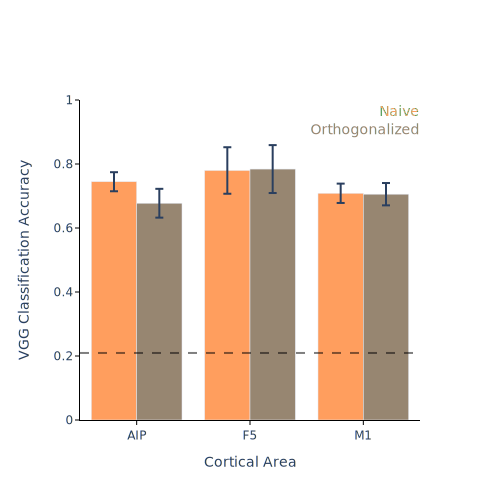

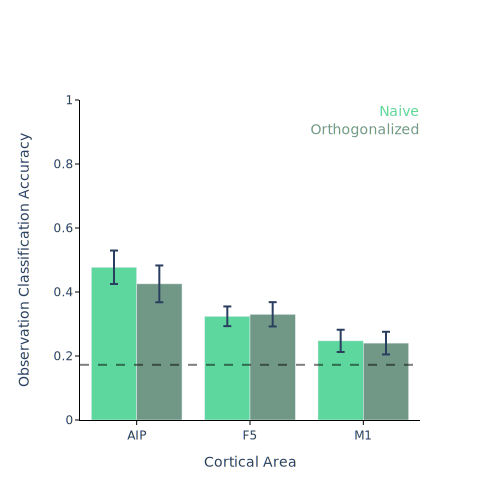

In [13]:
# and plot

# iterate through contexts
truenames  = ['VGG','Observation']
truecolors = [['rgba(255, 118, 26, 0.7)','rgba(109, 83, 55, 0.7)'],
              ['rgba(26, 200, 118, 0.7)','rgba(55, 109, 83, 0.7)']]
for idx,context in enumerate(['active','passive']):
    fig = go.Figure()
    # fig.full_figure_for_development()
    fig.add_trace(go.Bar(
        name='Naive',
        marker_color=truecolors[idx][0],
        x=[0,1,2], y=mu['naive'].loc[:,context].to_list(),
        error_y=dict(type='data', array=se['naive'].loc[:,context].to_list())
    ))
    fig.add_trace(go.Bar(
        name='Orthogonalized',
        marker_color=truecolors[idx][1],
        x=[0,1,2], y=mu['orthogonalized'].loc[:,context].to_list(),
        error_y=dict(type='data', array=se['orthogonalized'].loc[:,context].to_list())
    ))

    fig.update_xaxes(ticks='outside',
                               tickwidth=1,
                               tickcolor='black',
                               ticklen=4,
                               linecolor='rgba(0,0,0,1)',
                               linewidth=1,
                               showgrid=False)

    fig.update_yaxes(ticks='outside',
                                   tickwidth=1,
                                   tickcolor='black',
                                   ticklen=4,
                                   linecolor='rgba(0,0,0,1)',
                                   linewidth=1,
                                   showgrid=False
                                   )

    # guess I gotta go low-level for this
    fig['layout']['xaxis']['title'] = 'Cortical Area'
    fig['layout']['xaxis']['range'] = [-0.5, 2.5]
    fig['layout']['yaxis']['title'] = f'{truenames[idx]} Classification Accuracy'
    fig['layout']['yaxis']['range'] = [0, 1]
    fig['layout']['xaxis']['ticktext'] = ['AIP','F5','M1']
    fig['layout']['xaxis']['tickvals'] = [0,1,2]

    fig.add_trace(
        go.Scatter(
            x=[-0.5,2.5],
            y=[df['chance'].loc[df['context']==context].mean() for _ in range(2)],
            name='chance',
            mode='lines',
            line={
                'color':f'rgba(0,0,0,0.5)',
                'dash':'dash'
            }
        ),
    )

    fig.update_layout(barmode='group',
        plot_bgcolor='rgba(0,0,0,0)' ,
        paper_bgcolor='rgba(0,0,0,0)',
        showlegend=False,
        autosize=False,
        width=500,
        height=500)

    # I also need to do janky things to make a custom legend, too! wow!

    colors = truecolors[idx]
    prepend=''
    for idx_,legent in enumerate(['Naive','Orthogonalized']):
        c  = colors[idx_]

        fig.add_annotation(xref='x domain',
                                         yref='y domain',
                                         x = 1,
                                         y = 1,
                                         text = prepend+legent,
                                         showarrow=False,
                                         font={
                                             'color':c,
                                             'size':14
                                             },
                                         align='right',
                                         valign='top',
                                         yanchor='top',
                                         xanchor='right')

        prepend+=' <br>' # needs a space

    fig.show(renderer="svg")
    fig.write_image(os.path.join('figs',f'{truenames[idx]}_Self.svg'))

# Decoding time 
- as in, performing regression to estimate the time relative to movement & hold onset from neural activity
- then doing CROSS-DECODING to prove it's shared across contexts

grab the data

no need to do ortho for this or the classification of objects

but you should *probably* do it for the subspace alignment stuff

(btw, grip x time or just grip effects for subspace alignment?)

(meh, focus on just grip effects for now. That's what you use for classification after all, so it's apples-to-apples.)

In [125]:
# train & test both ways: both leveraging the passive context as a training set, and evaluating its confound potential as a test set
# hmmm... I should really have reaction time stored *somewhere* in this db, no?
# too bad I don't! that'd be a KILLER thing to have...
# oh well, time w.r.t. alignments is still an o.k. thing to decode here
# now, self-classification

timedecs = dict()

for session in sessions:
    timedecs[session] = dict()
    
    for area in areas:
        timedecs[session][area] = dict()
        
        dp = DataPartitioner(session=session,
                            areas=[area],
                            aligns=['go cue onset','movement onset','hold onset'],
                            contexts=['active','passive'],
                            groupings=['context','alignment','time'])
        
        df = dp.readQuery(0)
        
        for align in ['go cue onset','movement onset','hold onset']:
            timedecs[session][area][align] = dict()
            
            df_active_trials = df[
                (df['context']=='active') & 
                (df['alignment']==align)
            ]

            df_passive_trials = df[
                (df['context']=='passive') & 
                (df['alignment']==align)
            ]
            
            for testcontext in ['active','passive']:
                print(f"{session} {area} {align} tested on {testcontext}")
                
                if testcontext=='passive':
                    test_t   = df_passive_trials['time']
                    train_df = df_active_trials
                    test_df  = df_passive_trials
                else:
                    test_t   = df_active_trials['time']
                    train_df = df_passive_trials
                    test_df  = df_active_trials

                neurcount     = len(dp.get('neuronColumnNames'))
                pccount       = 30
                nsplits       = 5
                
                # yeah, just raw kfold. would probably be better if I did trial-fold, but honestly, this is 100% just to get the delta-mu problem sorted out. In the end it still has to generalize to a wholly new context with unmatched trials.
                # idea: turntable-fold? Yeah maybe... provided I can account for repertoire shifts
                kf      = KFold(n_splits=nsplits,shuffle=False)
                splits  = kf.split(test_t)
                splits  = list(splits) # store as list to allow it to be used many of time
                deltamu = []

                # step 1: find the deltamu for each split
                # no subspace ortho here
                for train_,_ in splits:
                    train_mu  = train_df[dp.get('neuronColumnNames')].mean()
                    test_mu   = test_df[dp.get('neuronColumnNames')].iloc[train_].mean()
                    delta_mu  = train_mu - test_mu
                    deltamu  += [delta_mu.to_numpy()]

                # step 2: cross-validated model fitting & evaluation
                y        = []
                yhat     = []
                selfR2   = []
                crossR2  = []
                selfVE_regdim  = []
                crossVE_regdim = []
                selfVE_total   = []
                crossVE_total  = []
                

                trainX = train_df[dp.get('neuronColumnNames')]
                trainy = train_df['time']

                for fold,(_,test_) in enumerate(splits):
                    testX  = test_df[dp.get('neuronColumnNames')].iloc[test_]
                    testy  = test_df['time'].iloc[test_]

                    # find the deltamu nullspace to ensure generalization robust to repertoire shifts (i.e., ignore the dimensions that separate the contexts, focus on what they're doing in parallel!)
                    deltanull = null_space( np.matrix(deltamu[fold]) )

                    # now fit a PC model in the remaining space to make sure LDA input is well-conditioned (this improves cross-validated performance)
                    PCmdl = PCA(n_components=pccount)
                    trX_ = PCmdl.fit_transform(trainX.to_numpy() @ deltanull)
                    teX_ = PCmdl.transform(testX.to_numpy() @ deltanull)
                    try_ = trainy.to_numpy()
                    tey_ = testy.to_numpy()

                    # now let's fit an OLS model. Seriously. We bein' basic here.
                    Lregmdl = LinearRegression()
                    Lregmdl.fit(trX_,try_)
                    tey_hat = Lregmdl.predict(teX_)

                    y+=list(tey_)
                    yhat+=list(tey_hat)

                    selfR2  += [Lregmdl.score(trX_,try_)]
                    crossR2 += [Lregmdl.score(teX_,tey_)]
                    
                    # TOTAL VE by the linear regression dimension, with respect to all the neural data within the context (including the ones orthogonalized out by the PCA process)
                    ax = Lregmdl.coef_ / norm( Lregmdl.coef_ )
                    
                    selfVE_regdim  += [np.var( trX_ @ ax )]
                    crossVE_regdim += [np.var( teX_ @ ax )]
                    selfVE_total   += [np.sum( np.var( trainX.to_numpy(),axis=0 ) )]
                    crossVE_total  += [np.sum( np.var( testX.to_numpy(),axis=0 ) )]
                    

                temp = dict()
                # note: y and yhat are the cross-validated values. only selfR2 is a record of the training set performance.
                temp['y'] = y
                temp['yhat'] = yhat
                temp['trainR2'] = selfR2
                temp['testR2'] = crossR2
                temp['trainVE_regdim']  = selfVE_regdim
                temp['testVE_regdim'] = crossVE_regdim
                temp['trainVE_total']   = selfVE_total
                temp['testVE_total']  = crossVE_total
                
                # also save variance explained by the time-decoding axis

                timedecs[session][area][align][testcontext+"_test"] = temp

                print(f"    Number of neurons = {len(dp.get('neuronColumnNames'))}")
                print(f"    Training R^2 = {np.mean(selfR2)}")
                print(f"    Test R^2 = {np.mean(crossR2)}")
                print(f"    Training VE_regdim = {np.mean(selfVE_regdim)}")
                print(f"    Test VE_regdim = {np.mean(crossVE_regdim)}")
                print(f"    Training VE_total = {np.mean(selfVE_total)}")
                print(f"    Test VE_total = {np.mean(crossVE_total)}")
                print()

Zara64 AIP go cue onset tested on active
    Number of neurons = 121
    Training R^2 = 0.5821653179666626
    Test R^2 = 0.462539639691554
    Training VE_regdim = 0.23585380150569857
    Test VE_regdim = 0.1217688846685202
    Training VE_total = 3.473825999199002
    Test VE_total = 3.1012368305580416

Zara64 AIP go cue onset tested on passive
    Number of neurons = 121
    Training R^2 = 0.6300835928904497
    Test R^2 = 0.4716321980714248
    Training VE_regdim = 0.16213484797548355
    Test VE_regdim = 0.08681239582681688
    Training VE_total = 3.159162030571484
    Test VE_total = 3.4198342069864287

Zara64 AIP movement onset tested on active
    Number of neurons = 121
    Training R^2 = 0.7224359973220097
    Test R^2 = 0.5737146455980707
    Training VE_regdim = 0.22553373649305147
    Test VE_regdim = 0.12328231057548714
    Training VE_total = 4.060135735777288
    Test VE_total = 3.2745524963568924

Zara64 AIP movement onset tested on passive
    Number of neurons = 121


    Number of neurons = 108
    Training R^2 = 0.7559533534087961
    Test R^2 = 0.40607265199122977
    Training VE_regdim = 0.2262574166637849
    Test VE_regdim = 0.0545626672502034
    Training VE_total = 4.5568899084655135
    Test VE_total = 2.951651388763488

Zara70 F5 hold onset tested on active
    Number of neurons = 108
    Training R^2 = 0.7530389719984598
    Test R^2 = 0.1898032686674493
    Training VE_regdim = 0.130817541361088
    Test VE_regdim = 0.04330915214893618
    Training VE_total = 3.164745203886407
    Test VE_total = 4.434542361974284

Zara70 F5 hold onset tested on passive
    Number of neurons = 108
    Training R^2 = 0.7594854729879161
    Test R^2 = 0.19490264457036105
    Training VE_regdim = 0.2485643634311358
    Test VE_regdim = 0.031377533258463854
    Training VE_total = 4.568936982293666
    Test VE_total = 3.101866986554258

Zara70 M1 go cue onset tested on active
    Number of neurons = 183
    Training R^2 = 0.1630585256396955
    Test R^2 = -0

Moe50 AIP go cue onset tested on active
    Number of neurons = 67
    Training R^2 = 0.29608819619969884
    Test R^2 = 0.3290058446076277
    Training VE_regdim = 0.0466228517560139
    Test VE_regdim = 0.03798973390408576
    Training VE_total = 1.5353271023464266
    Test VE_total = 1.9039161286997743

Moe50 AIP go cue onset tested on passive
    Number of neurons = 67
    Training R^2 = 0.4525993026538543
    Test R^2 = 0.11175088197779814
    Training VE_regdim = 0.08112539890583916
    Test VE_regdim = 0.04052162510937476
    Training VE_total = 1.9731834307125387
    Test VE_total = 1.4803170340909164

Moe50 AIP movement onset tested on active
    Number of neurons = 67
    Training R^2 = 0.6847540737127753
    Test R^2 = 0.610283089090655
    Training VE_regdim = 0.18064126899436134
    Test VE_regdim = 0.13789336378731382
    Training VE_total = 2.079261495482198
    Test VE_total = 2.475538137897818

Moe50 AIP movement onset tested on passive
    Number of neurons = 67
    T

In [126]:
# prep the data for plotting

# get the data ready for plotting
# x = before
# y = after

rg=np.random.default_rng()

y       = []
yhat    = []
trainR2 = []
testR2  = []
trainVE_regdim = []
testVE_regdim  = []
trainVE_total  = []
testVE_total   = []
session_ = []
area_    = []
align_   = []
testcontext_ = []

for session in timedecs:
    for area in timedecs[session]:
        for align in timedecs[session][area]:
            for testcontext in timedecs[session][area][align]:
                temp = timedecs[session][area][align][testcontext]
                len_ = len(temp['y'])
                
                # randomly sample 1% of these points because this is ridiculous
                keepinds = list( rg.choice(len_,int(len_/100)) )
                
                # reset len
                len_     = len(keepinds)
                
                
                # don't worry too much about within-run variances, SEMs, or such. We're pooling & doing SEMs based on that                
                y       += [temp['y'][idx] for idx in keepinds]
                yhat    += [temp['yhat'][idx] for idx in keepinds]
                trainR2 += [np.mean(temp['trainR2']) for _ in range(len_)]
                testR2  += [np.mean(temp['testR2']) for _ in range(len_)]
                trainVE_regdim += [np.mean(temp['trainVE_regdim']) for _ in range(len_)]
                testVE_regdim  += [np.mean(temp['testVE_regdim']) for _ in range(len_)]
                trainVE_total  += [np.mean(temp['trainVE_total']) for _ in range(len_)]
                testVE_total   += [np.mean(temp['testVE_total']) for _ in range(len_)]
                session_ += [session for _ in range(len_)]
                area_    += [area for _ in range(len_)]
                align_   += [align for _ in range(len_)]
                testcontext_ += [testcontext for _ in range(len_)]
        
dd = {'y':y,
      'yhat':yhat,
      'trainR2':trainR2,
      'testR2':testR2,
      'trainVE_regdim':trainVE_regdim,
      'testVE_regdim':testVE_regdim,
      'trainVE_total':trainVE_total,
      'testVE_total':testVE_total,
      'session':session_,
      'area':area_,
      'align':align_,
      'testcontext':testcontext_}

df = pd.DataFrame(dd)
fname = os.path.join('pythonfigures','timeregression.json')
df.to_json(fname) # to sql was probably better...

print(df)

         y        yhat   trainR2    testR2  trainVE_regdim  testVE_regdim  \
0       65 -123.498529  0.582165  0.462540        0.235854       0.121769   
1     -125 -192.437896  0.582165  0.462540        0.235854       0.121769   
2     -435 -108.412626  0.582165  0.462540        0.235854       0.121769   
3      -75  -96.027704  0.582165  0.462540        0.235854       0.121769   
4     -385 -196.575198  0.582165  0.462540        0.235854       0.121769   
...    ...         ...       ...       ...             ...            ...   
19048 -135   96.168494  0.794263  0.138775        0.312333       0.025894   
19049  265   36.680698  0.794263  0.138775        0.312333       0.025894   
19050  345   10.785184  0.794263  0.138775        0.312333       0.025894   
19051 -265 -103.704709  0.794263  0.138775        0.312333       0.025894   
19052 -185  -44.986573  0.794263  0.138775        0.312333       0.025894   

       trainVE_total  testVE_total session area         align   testcontext

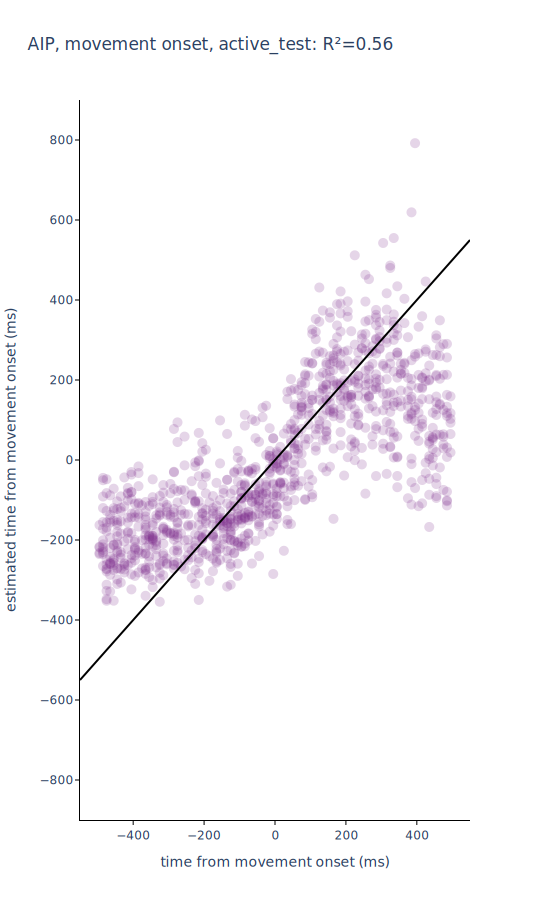

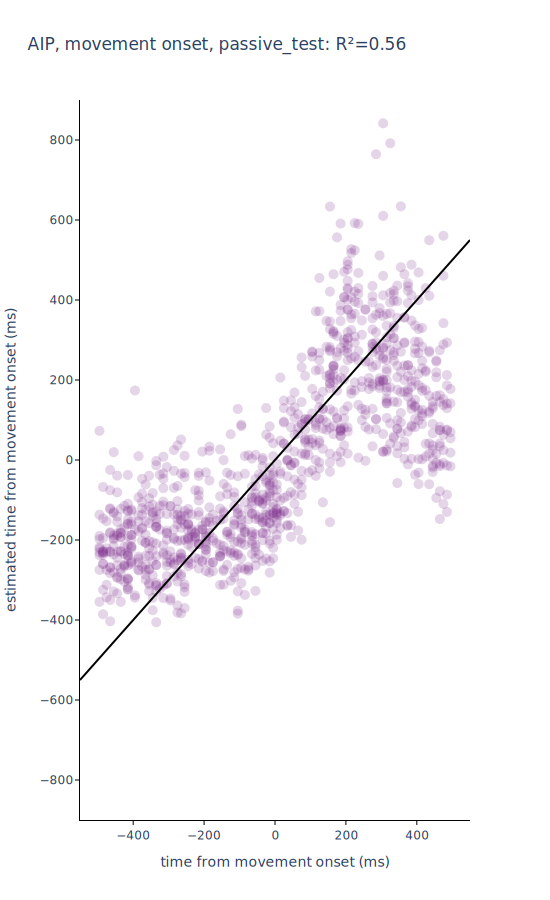

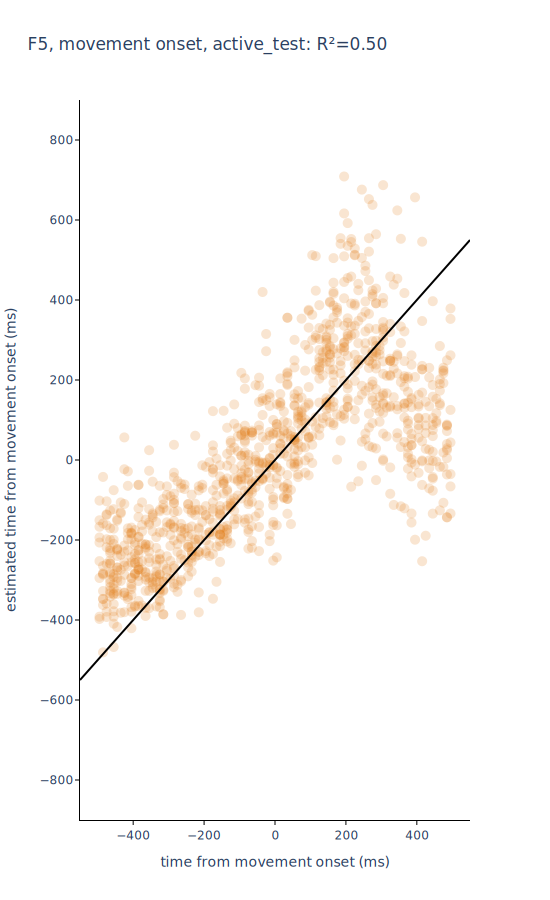

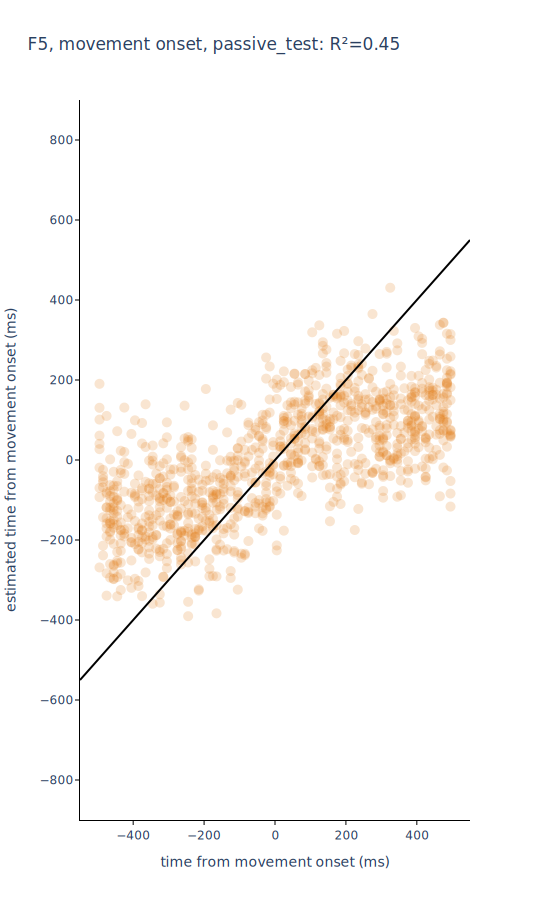

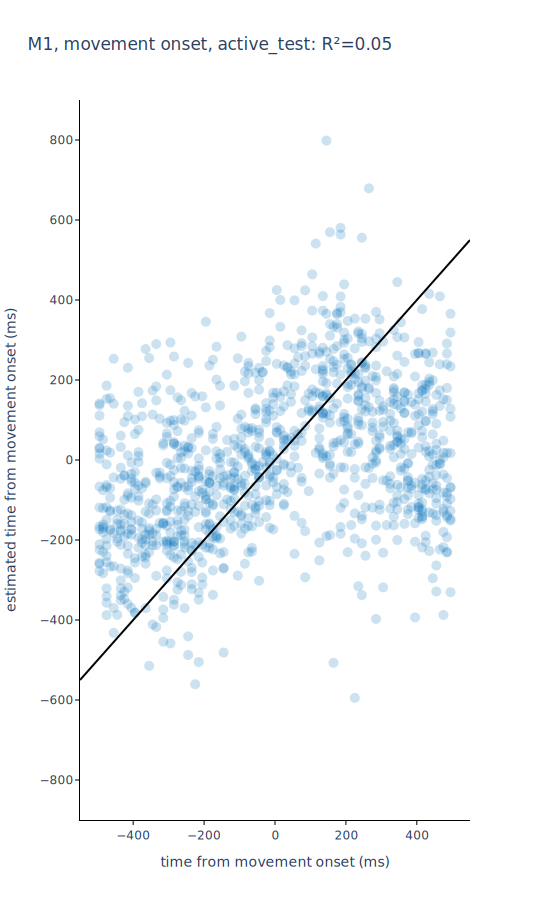

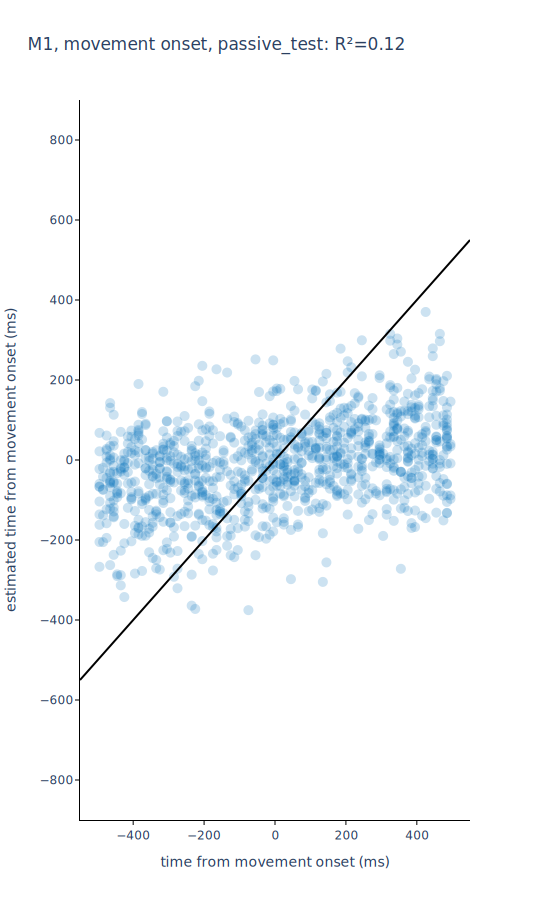

In [147]:
fname  = os.path.join('pythonfigures','timeregression.json')
df     = pd.read_json(fname)
colors = pd.read_csv(os.path.join('pythonfigures','colors.csv'))

# first off, make a scatterplot for each area x align x test context
for area in pd.unique(df['area']):
    # movement onset is clearly the best-performing alignment, so just roll with that
    for align in ['movement onset']: #pd.unique(df['align']):
        for testcontext in pd.unique(df['testcontext']):
            c = colors[colors['Area']==area].to_numpy()
            c = c[0][:3]
            scatterdf = df[['y','yhat','testR2']][(df['testcontext']==testcontext) &
                        (df['area']==area) &
                        (df['align']==align)]
            
            fig = go.Figure()
            fig.add_trace(
                go.Scatter(
                    x=scatterdf['y'], 
                    y=scatterdf['yhat'], 
                    mode='markers', 
                    marker=dict(
                        color=f'rgba({c[0]},{c[1]},{c[2]},0.2)', 
                        size=10), 
                    showlegend=False)
            )
            fig.update_layout(
                title=f"{area}, {align}, {testcontext}: R\u00B2={scatterdf['testR2'].mean():.2f}", 
                xaxis_title=f'time from {align} (ms)', 
                yaxis_title=f'estimated time from {align} (ms)', 
                xaxis_showgrid=False, 
                yaxis_showgrid=False, 
                plot_bgcolor='rgba(0,0,0,0)',
                xaxis_range=[-550, 550], 
                yaxis_range=[-900, 900],
                width=550,
                height=900
            )
            fig.update_xaxes(ticks='outside',
                                       tickwidth=1,
                                       tickcolor='black',
                                       ticklen=4,
                                       linecolor='rgba(0,0,0,1)',
                                       linewidth=1,
                                       showgrid=False)

            fig.update_yaxes(ticks='outside',
                                           tickwidth=1,
                                           tickcolor='black',
                                           ticklen=4,
                                           linecolor='rgba(0,0,0,1)',
                                           linewidth=1,
                                           showgrid=False
                                           )
            fig.add_shape(type='line', 
                          x0=-550, 
                          y0=-550, 
                          x1=550, 
                          y1=550, 
                          line=dict(
                              color='black', 
                              width=2)
            )
            fig.show(renderer="svg")

In [120]:
c = colors[colors['Area']==area].to_numpy()
c = c[0][:3]
print(c)

[125 46 141]


# Appendix: ChatGPT-generated barplot

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Hello', x=['Hello'], y=[5], error_y=dict(type='data', array=[1], color='midnightblue'), marker_color='midnightblue'),
    go.Bar(name='World', x=['World'], y=[4], error_y=dict(type='data', array=[2], color='hotpink'), marker_color='hotpink'),
    go.Bar(name='Foo', x=['Foo'], y=[3], error_y=dict(type='data', array=[1], color='darkred'), marker_color='darkred')
])

fig.update_layout(title='dog water', xaxis_title='Labels', yaxis_title='dog water')

fig.show(renderer="svg")